In this notebook we attempted to do a linear combination of features in order to construct the graph. The idea was to use a grid search to find a combination which would optimize the weights. The output was given by heat diffusion from a starting node (country where the event happened) compared was the measured relative reactions (normalized twitter reactions). 

Unfortunately we ran into issues with the PyGSP library at the level of the graph construction due to low first eigenvalues. We did not have time to explore the origin of this problem before the end of Milestone 3

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from pygsp import graphs, filters, plotting
from scipy.spatial import distance
import matplotlib.pyplot as plt


## Load the standardized data

Note that this data was create using the SVR Model Notebook

In [2]:
file_path = os.path.join(os.getcwd(), "StandardizedData")

directory = os.path.dirname(file_path)

religion_distance_df = pd.read_pickle("religion.pkl")
religion_distance_df.drop("UM", axis = 1, inplace = True)
religion_distance_df = religion_distance_df-religion_distance_df.min().min()

neib_distance_df =  pd.read_pickle("neighbor.pkl")
neib_distance_df = neib_distance_df-neib_distance_df.min().min()

flight_distance_df =  pd.read_pickle("flight.pkl")
flight_distance_df = flight_distance_df-flight_distance_df.min().min()

hop_distance_df = pd.read_pickle("hop.pkl")
hop_distance_df = hop_distance_df-hop_distance_df.min().min()

real_distance_df = pd.read_pickle("real_distance.pkl")
real_distance_df = real_distance_df-real_distance_df.min().min()

language_df = pd.read_pickle("language.pkl")
language_df.drop("UM", axis = 1, inplace = True)
language_df = language_df-language_df.min().min()


summary_norm_df= pd.read_pickle("summary_norm.pkl")

# Get the position of the nodes
c_data = pickle.load(open('../DataEnriching/data.pickle','rb'))
c_data.drop("United States Minor Outlying Islands",inplace = True)
countries = c_data.index.tolist()


country_pos = np.array(c_data[['latlng']].as_matrix())
country_pos = [ np.array(x[0]) for x in country_pos]
country_pos = np.vstack(country_pos)
country_pos = np.transpose(np.vstack((country_pos[:,1], country_pos[:,0])))

event_list = ['Charlie-Hebdo','Istanbul','Nigeria_2015','Orlando','Bruxelles','Pakistan','Lebanon','Nigeria_2016']
c_event_list = ['FR','TR','NG','US','BE','PK','LB','NG']
countries_events = ['France','Turkey','Nigeria','United States', 'Belgium','Pakistan','Lebanon','Nigeria']

## Create the Graphs

In [3]:
def create_graph(mat):
    # Create the graph
    G = graphs.Graph(mat)
    G.set_coordinates(country_pos)
    G.compute_fourier_basis()
    return G
    
def create_sets(event_list,c_event_list):
    for i in range(len(event_list)):
        
        # country of the event and its name : 
        c_event = c_event_list[i]
        event = event_list[i]
        
        # Y vector output
        if i == 0 : 
            Y =  np.array(list(summary_norm_df.loc[:,event])).reshape(1,-1)
        else : 
            Y =  np.r_[Y, np.array(list(summary_norm_df.loc[:,event])).reshape(1,-1)]        
            
    return Y

def heat_diffusion(G, num_tweets_in_country, country):
    
    NODE = np.where(country == language_df.index)[0][0]
    
    print(NODE)
    # Create the heat diffusion filter
    filt = filters.Heat(G, tau=100)

    # Create the signal for the given country
    signal = np.zeros(G.N)
    signal[NODE] = num_tweets_in_country[NODE]/1000

    # Apply the filter to the signal
    filtered_s = filt.filter(signal)

    return filtered_s

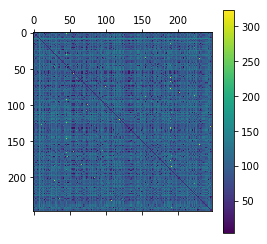

bloop


AssertionError: 

In [4]:
religion_mat = religion_distance_df.as_matrix()
neib_mat = neib_distance_df.as_matrix()
flight_mat = flight_distance_df.as_matrix()
hop_distance_mat = hop_distance_df.as_matrix()
real_distance_mat = real_distance_df.as_matrix()
language_distance_mat = language_df.as_matrix()

alpha_rel_range = np.linspace(10,100,10)
alpha_neib_range = np.linspace(10,100,10)
alpha_flight_range= np.linspace(10,100,10)
alpha_hop_range = np.linspace(10,100,10)
alpha_real_dist_range = np.linspace(10,100,10)
alpha_lang_range = np.linspace(10,100,10)

Y = create_sets(event_list, c_event_list)

best = dict()

best_error = np.inf

for alpha_rel in alpha_rel_range:
    for alpha_neib in alpha_neib_range:
        for alpha_flight in alpha_flight_range:
            for alpha_hop in alpha_hop_range:
                for alpha_real_dist in alpha_real_dist_range:
                    for alpha_lang in alpha_lang_range:
                        final_mat = alpha_rel*religion_mat
                        final_mat += alpha_neib*neib_mat
                        final_mat += alpha_flight*flight_mat
                        final_mat += alpha_hop*hop_distance_mat
                        final_mat += alpha_real_dist*real_distance_mat
                        final_mat += alpha_lang*language_distance_mat
                        #final_mat -= final_mat.min().min()
                        plt.matshow(final_mat)
                        plt.colorbar()
                        plt.show()
                        np.fill_diagonal(final_mat, 0, wrap=False)
                        
                        G = create_graph(final_mat)
                        error = 0
                        
                        for idx, country in enumerate(c_event_list):
                            num_tweets_in_country = Y[idx,:] 
                            filtered_s= heat_diffusion(G, num_tweets_in_country, country)
                            error += distance.euclidean(num_tweets_in_country,filtered_s)
                            signal[country] = filtered_s
                            
                        if error < best_error:
                            best["error"] = error
                            best["weights"]  = final_mat
                            best["graph"] = G
                            best["alpha_rel"] = alpha_rel
                            best["alpha_neib"] = alpha_neib
                            best["alpha_flight"] = alpha_flight
                            best["alpha_hop"] = alpha_hop
                            best["alpha_real_dist"] = alpha_real_dist
                            best["alpha_lang"] = alpha_lang
                            best["signal"] = signal


In [ ]:
for signal in enumerate(best["signal"]):
    NODE = countries_events[i]
    best["graph"].G.plot_signal(signal, vertex_size=50, highlight=NODE)
